In [1]:
# ref: 

# https://alexioannides.com/2018/11/07/bayesian-regression-in-pymc3-using-mcmc-variational-inference/
# https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html

# http://stronginference.com/pymc3-release.html
# https://docs.pymc.io/notebooks/getting_started.html

# https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501

About NUTS [a self tuning form of HMC]
http://stronginference.com/pymc3-release.html
    
Though the version 2 and version 3 models are superficially similar (by design), there are very different things happening underneath when sampleis called in either case. By default, the PyMC3 model will use a form of gradient-based MCMC sampling, a self-tuning form of Hamiltonian Monte Carlo, called NUTS. Gradient based methods serve to drastically improve the efficiency of MCMC, without the need for running long chains and dropping large portions of the chains due to lack of convergence. Rather than conditionally sampling each model parameter in turn, the NUTS algorithm walks in k-space (where k is the number of model parameters), simultaneously updating all the parameters as it leap-frogs through the parameter space. Models of moderate complexity and size that would normally require 50,000 to 100,000 iterations now typically require only 2000-3000.

Unless specified otherwise, PyMC3 will assign the NUTS sampler to all the variables of the model. This happens here because our model contains only continuous random variables; NUTS will not work with discrete variables because it is impossible to obtain gradient information from them. Discrete variables are assigned the Metropolissampling algorithm (step method, in PyMC parlance). The next thing that happens is that the variables' initial values are assigned using Automatic Differentiation Variational Inference (ADVI). This is an approximate Bayesian inference algorithm that we have added to PyMC — more on that later. Though it can be used for inference in its own right, here we are using it merely to find good starting values for NUTS (in practice, this is important for getting NUTS to run well). Its an excessive step for small models like this, but it is the default behavior, designed to try and guarantee a good MCMC run.

In [2]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
np.random.seed(23)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [3]:
''' function definitions '''
# true low-fidelity and true high-fidelity models
f_l = lambda x: np.sin(8.0 * np.pi * x)
f_h = lambda x: (x - np.sqrt(2.0)) * f_l(x) ** 2

In [4]:
N_l = 51 # number of low fidelity data observations
N_h = 14 # number of high fidelity data observations

# [X_l,Y_l] and [X_h,Y_h] are low are high fidelity data respectively.
X_l = np.linspace(0.0, 1.0, N_l)[:, None]

# # for not-nested data
# X_h = np.random.rand(N_h, 1)

# # for nested data
perm = np.random.permutation(N_l)
X_h = X_l[perm[0:N_h]]

Y_l = f_l(X_l)
Y_h = f_h(X_h)

print (X_l.shape, Y_l.shape)
print (X_h.shape, Y_h.shape)

(51, 1) (51, 1)
(14, 1) (14, 1)


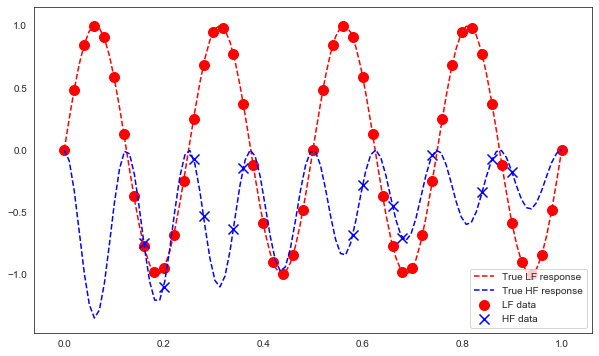

In [5]:
# just to show the plot
X_p = np.linspace(0.0, 1.0, 100)[:, None]

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot(X_p, f_l(X_p), 'r--', label='True LF response')
ax.scatter(X_l, Y_l, color='red', marker='o', s=100, label='LF data')
ax.plot(X_p, f_h(X_p), 'b--', label='True HF response')
ax.scatter(X_h, Y_h, color='blue', marker='x', s=100, label='HF data')

ax.legend()
plt.show()

## Pymc model

In [6]:
# BNN parameters
H = 20
d = [X_l.shape[1], H, H, 2]  # num_neurons_per_layer
act_func = pm.math.tanh

In [7]:
# Initialize random weights and biases between each layer
init_Ws = []
init_bs = []
for i in range(len(d)-1):
    init_W = np.random.randn(d[i], d[i+1]).astype(floatX)
    init_b = np.random.randn(d[i+1]).astype(floatX)
    init_Ws.append(init_W)
    init_bs.append(init_b)
    
# DNN
def DNN(x_tensor, Ws, bs):
    h = act_func(pm.math.dot(x_tensor,Ws[0])+bs[0])
    for i in range(1,len(d)-2):
        h = act_func(pm.math.dot(h,Ws[i])+bs[i])
    act_out = pm.math.dot(h,Ws[-1])+bs[-1]
    return act_out
    
    
with pm.Model() as neural_network:
    # Trick: Turning inputs and outputs into shared variables 
    # It's still the same thing, but we can later change the values of the shared variable
    # (to switch in the test-data later) and pymc3 will just use the new data.
    # Kind-of like a pointer we can redirect.
    # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
    y_tensor_low = theano.shared(Y_l)
    x_tensor_low = theano.shared(X_l)
    
    y_tensor_high = theano.shared(Y_h)
    x_tensor_high = theano.shared(X_h)

    #PRIOR
    # Weights and biases 
    Ws = []
    bs = []
    for i in range(len(d)-1):
        W = pm.Normal('W_'+str(i), mu=0, sigma=1, shape=(d[i], d[i+1]), testval=init_Ws[i])
        b = pm.Normal('b_'+str(i), mu=0, sigma=1, shape=(d[i+1]), testval=init_bs[i])
        Ws.append(W)
        bs.append(b)
        
    # Build neural-network using activation function
    act_out_low = DNN(x_tensor_low, Ws, bs)[:,0][:,None]
    act_out_high = DNN(x_tensor_high, Ws, bs)[:,1][:,None]

    # LIKELIHOOD
    out1 = pm.Normal('out1', mu=act_out_low, sigma=0.01, observed=y_tensor_low)
    out2 = pm.Normal('out2', mu=act_out_high, sigma=0.01, observed=y_tensor_high)

## Checking prior draws

In [8]:
# Now we would like to make some predictions
# Namely, we wish to predict at this dense set of points:
X_p = np.linspace(0.0, 1.0, 100)[:, None]
print (X_p.shape)

(100, 1)


(10, 100, 2)
(10, 100)
(10, 100)


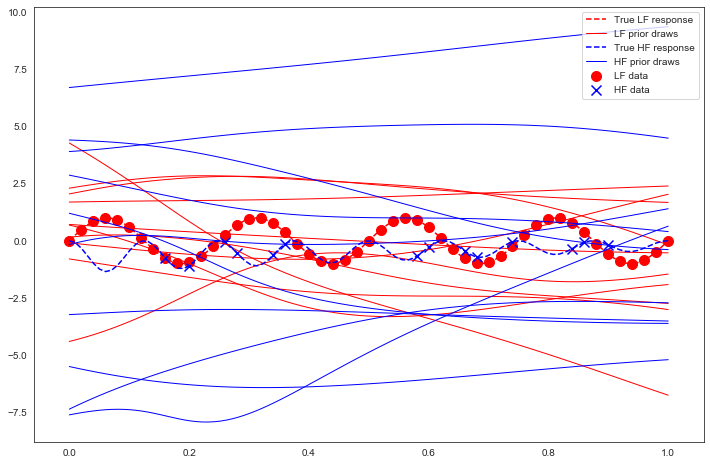

In [9]:
with neural_network:
    n_plot = 10 # number of prediction samples to plot
    
    def prior_sampler():
        Ws_p = []
        bs_p = []
        for i in range(len(d)-1):
            W_p = Ws[i].random()
            b_p = bs[i].random()
            Ws_p.append(W_p)
            bs_p.append(b_p)
        return Ws_p, bs_p
    
    preds = []
    for j in range(n_plot):
        Ws_p, bs_p = prior_sampler()
        pred = DNN( X_p, Ws_p , bs_p )
        preds. append (pred)

    preds = [preds[j].eval() for j in range(len(preds))]
    preds = np.asarray(preds)

    outputs_low = preds[:,:,0]
    outputs_high = preds[:,:,1]

    print(np.shape(preds))
    print(np.shape(outputs_low))
    print(np.shape(outputs_high))

    #########
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)

    ax.plot(X_p, f_l(X_p), 'r--', label='True LF response')
    ax.scatter(X_l, Y_l, color='red', marker='o', s=100, label='LF data')
    ax.plot(X_p,outputs_low[0].T, lw=1, label='LF prior draws', color='red')
    ax.plot(X_p,outputs_low[1:n_plot].T, lw=1, color='red')

    ax.plot(X_p, f_h(X_p), 'b--', label='True HF response')
    ax.scatter(X_h, Y_h, color='blue', marker='x', s=100, label='HF data')
    ax.plot(X_p,outputs_high[0].T, lw=1, label='HF prior draws',color='blue')
    ax.plot(X_p,outputs_high[1:n_plot].T, lw=1, color='blue')

    ax.legend()
    plt.show()
    #########

In [10]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

## Drawing samples

In [11]:
# Carrying out MCMC
with neural_network:
    trace = pm.sample(draws=1000, tune=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Waiting for existing lock by process '32115' (I am process '32334')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/sharmila/.theano/compiledir_Darwin-16.7.0-x86_64-i386-64bit-i386-3.6.10-64/lock_dir
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_2, W_2, b_1, W_1, b_0, W_0]
Sampling 2 chains, 30 divergences: 100%|██████████| 4000/4000 [21:03<00:00,  3.16draws/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match

In [12]:
print(trace.get_values('W_0').shape)
print(trace['W_0'].shape)
print(trace['W_0'].shape[0])

(2000, 1, 20)
(2000, 1, 20)
2000


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"W_0[0,0]",-1.296,1.414,-4.037,1.100,0.737,0.590,4.0,3.0,4.0,27.0,1.54
"W_0[0,1]",2.802,1.902,0.035,5.526,1.260,1.045,2.0,2.0,3.0,50.0,1.84
"W_0[0,2]",-1.231,1.608,-4.392,0.888,1.022,0.835,2.0,2.0,3.0,24.0,1.79
"W_0[0,3]",-1.219,1.917,-4.449,1.335,1.249,1.024,2.0,2.0,3.0,22.0,2.03
"W_0[0,4]",0.429,2.320,-3.212,3.599,1.545,1.276,2.0,2.0,3.0,23.0,2.14
...,...,...,...,...,...,...,...,...,...,...,...
"W_2[18,1]",2.002,0.723,0.788,2.984,0.453,0.381,3.0,2.0,3.0,48.0,1.81
"W_2[19,0]",0.776,1.240,-1.274,2.568,0.833,0.691,2.0,2.0,3.0,19.0,2.22
"W_2[19,1]",-0.168,1.721,-1.751,2.796,1.151,0.952,2.0,2.0,3.0,11.0,2.33
b_2[0],0.437,0.485,-0.569,1.325,0.117,0.090,17.0,15.0,16.0,46.0,1.10


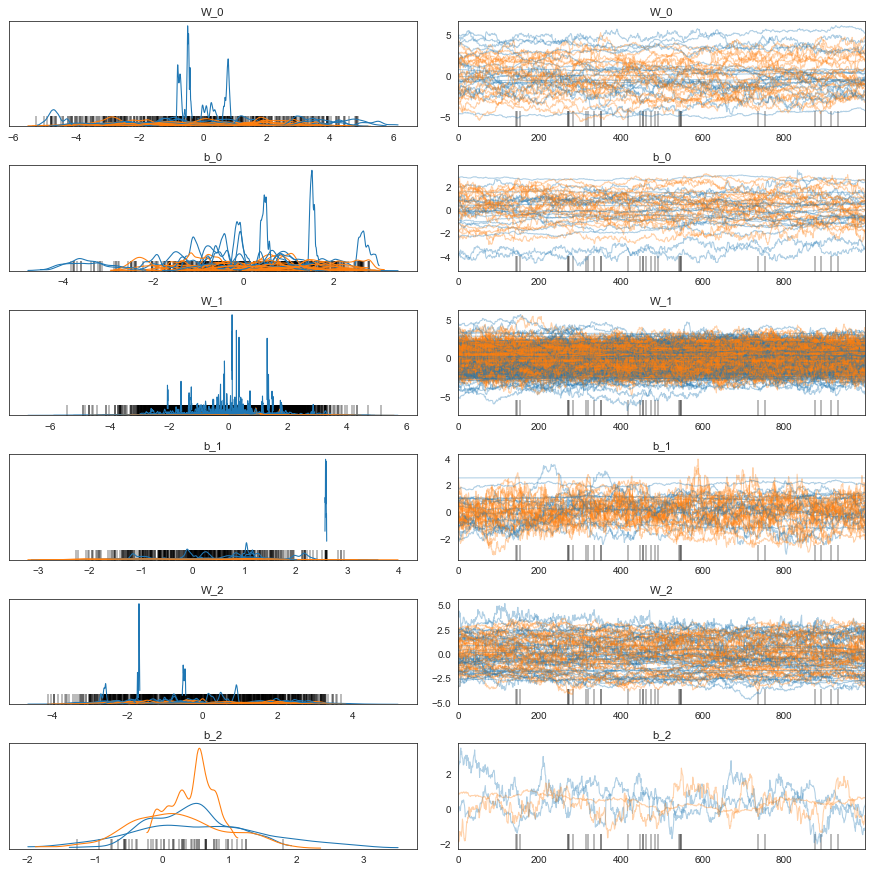

In [13]:
pm.traceplot(trace)
pm.summary(trace)
# pm.forestplot(trace)

## Checking posterior draws

INFO (theano.gof.compilelock): Waiting for existing lock by process '32115' (I am process '32334')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/sharmila/.theano/compiledir_Darwin-16.7.0-x86_64-i386-64bit-i386-3.6.10-64/lock_dir


(10, 100, 2)
(10, 100)
(10, 100)


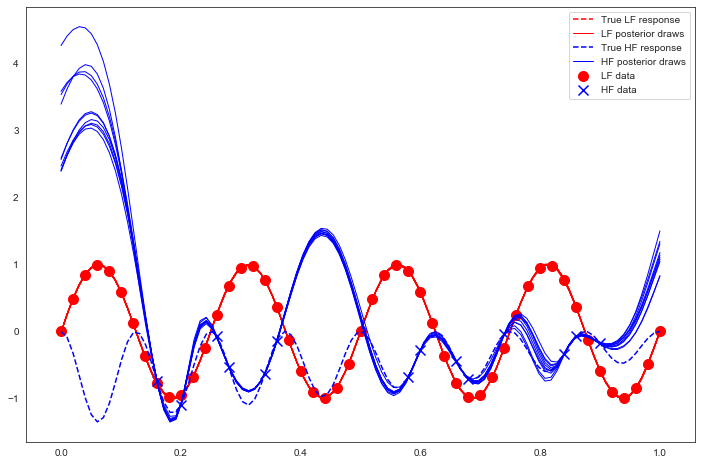

In [15]:
n_plot = 10 # number of prediction samples to plot

def posterior_sampler(j):
    Ws_post = []
    bs_post = []
    for i in range(len(d)-1):
        W_post = trace['W_'+str(i)][ j ]
        b_post = trace['b_'+str(i)][ j ]
        Ws_post.append(W_post)
        bs_post.append(b_post)
    return Ws_post, bs_post

preds = []
for j in range(n_plot):
    Ws_post, bs_post = posterior_sampler(j)
    pred = DNN( X_p, Ws_post, bs_post )
    preds. append (pred)

preds = [preds[j].eval() for j in range(len(preds))]
preds = np.asarray(preds)

outputs_low = preds[:,:,0]
outputs_high = preds[:,:,1]

print(np.shape(preds))
print(np.shape(outputs_low))
print(np.shape(outputs_high))

#########
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

ax.plot(X_p, f_l(X_p), 'r--', label='True LF response')
ax.scatter(X_l, Y_l, color='red', marker='o', s=100, label='LF data')
ax.plot(X_p,outputs_low[0].T, lw=1, label='LF posterior draws', color='red')
ax.plot(X_p,outputs_low[1:n_plot].T, lw=1, color='red')

ax.plot(X_p, f_h(X_p), 'b--', label='True HF response')
ax.scatter(X_h, Y_h, color='blue', marker='x', s=100, label='HF data')
ax.plot(X_p,outputs_high[0].T, lw=1, label='HF posterior draws',color='blue')
ax.plot(X_p,outputs_high[1:n_plot].T, lw=1, color='blue')

ax.legend()
plt.show()

(70, 100, 2)
(70, 100)
(70, 100)


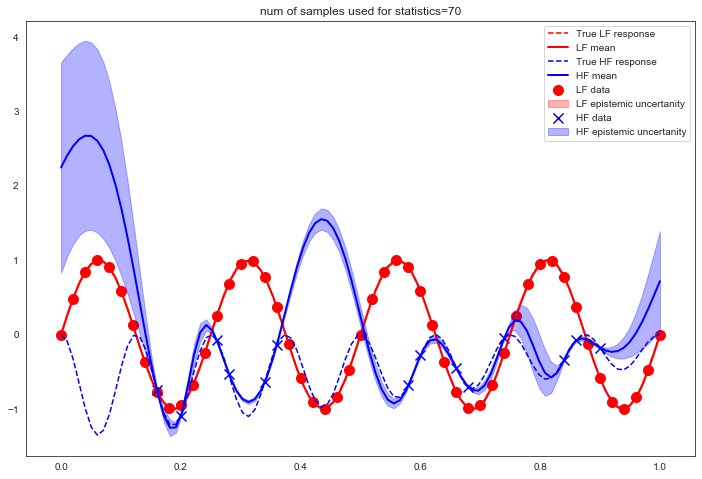

In [20]:
n_stat = 70 # number of prediction samples to calculate statistics

preds = []
for j in range(n_stat):
    Ws_post, bs_post = posterior_sampler(j)
    pred = DNN( X_p, Ws_post, bs_post )
    preds. append (pred)

preds = [preds[j].eval() for j in range(len(preds))]
preds = np.asarray(preds)

outputs_low = preds[:,:,0]
outputs_high = preds[:,:,1]

print(np.shape(preds))
print(np.shape(outputs_low))
print(np.shape(outputs_high))

#########
mean_outputs_low = np.mean(outputs_low, axis=0)
stddev_outputs_low = np.std(outputs_low, axis=0)
mean_outputs_high = np.mean(outputs_high, axis=0)
stddev_outputs_high = np.std(outputs_high, axis=0)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

ax.plot(X_p, f_l(X_p), 'r--', label='True LF response')
ax.scatter(X_l, Y_l, color='red', marker='o', s=100, label='LF data')
ax.plot(X_p, mean_outputs_low ,lw=2, label='LF mean', color='red')
ax.fill_between(X_p.ravel(), (mean_outputs_low-1.96*stddev_outputs_low).ravel(), (mean_outputs_low+1.96*stddev_outputs_low).ravel(), alpha = 0.3, color = 'red',label='LF epistemic uncertanity')

ax.plot(X_p, f_h(X_p), 'b--', label='True HF response')
ax.scatter(X_h, Y_h, color='blue', marker='x', s=100, label='HF data')
ax.plot(X_p, mean_outputs_high ,lw=2, label='HF mean', color='blue')
ax.fill_between(X_p.ravel(), (mean_outputs_high-1.96*stddev_outputs_high).ravel(), (mean_outputs_high+1.96*stddev_outputs_high).ravel(), alpha = 0.3, color = 'blue',label='HF epistemic uncertanity')

plt.title('num of samples used for statistics='+str(n_stat))

ax.legend()
plt.show()

#******* Note the mssg:
The estimated number of effective samples is smaller than 200 for some parameters.

So for n_stat>70 its failing I think